### Initialization

In [6]:
%load_ext autoreload
%autoreload 2
%autosave 0
import os, glob
import re
import pathos
import pickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ternary
import alphashape
import descartes
import numpy as np
import numpy.random as rnd
from scipy import special, integrate, optimize, interpolate
from moment import *

# Directories
base_dir = os.path.expanduser("~/Dropbox/mm-astro/ew/python/")
os.chdir(base_dir)

# set up matplotlib
%matplotlib inline
matplotlib.rcParams['text.usetex']    = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb}'
matplotlib.rcParams['font.family']    = 'serif'
matplotlib.rcParams['font.size']      = '18'
matplotlib.rcParams['figure.figsize'] = 6.4, 4.8


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosave disabled


### preparation / tests of the neutrino_propagator class

In [215]:
# extract SnowGLoBES cross-sections
xs = np.loadtxt('/Users/jkopp/Dropbox/mm-astro/to/cross_sections/snowglobes/xs_ibd.dat')
np.savetxt('cross_sections/IBD.csv', np.array([1e3*10**xs[:,0], 1e-38*xs[:,4] * 10**xs[:,0]]).T,
           header='E [MeV]   \sigma [cm^2]')

xs = np.loadtxt('/Users/jkopp/Dropbox/mm-astro/to/cross_sections/snowglobes/xs_nue_O16.dat')
np.savetxt('cross_sections/nu_e_O.csv', np.array([1e3*10**xs[:,0], 1e-38*xs[:,1] * 10**xs[:,0]]).T,
           header='E [MeV]   \sigma [cm^2]')

xs = np.loadtxt('/Users/jkopp/Dropbox/mm-astro/to/cross_sections/snowglobes/xs_nuebar_O16.dat')
np.savetxt('cross_sections/nubar_e_O.csv', np.array([1e3*10**xs[:,0], 1e-38*xs[:,1] * 10**xs[:,0]]).T,
           header='E [MeV]   \sigma [cm^2]')

In [566]:
189/135. * 5 # 135 pixels in fig. 4 of https://arxiv.org/abs/0704.0458 correspond to 5 kpc

7.0

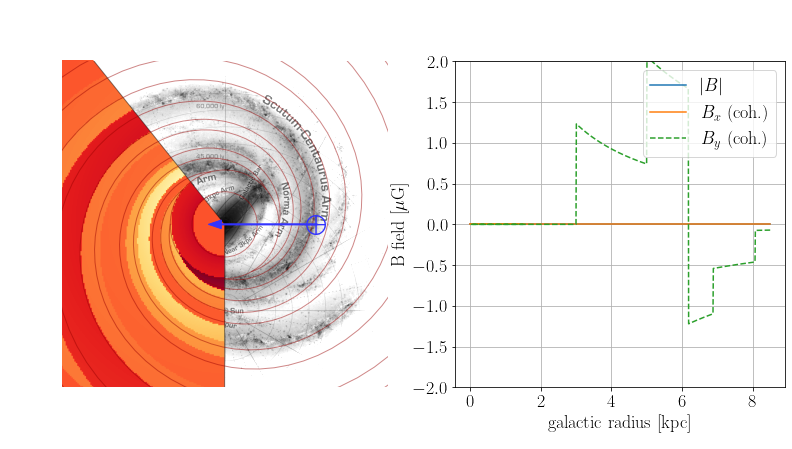

In [137]:
p = neutrino_propagator(mu_range=[0])
fig = p.generate_B_field_gal(plot=True, mu_range=[0])
fig.get_axes()[1].set_visible(False)
extent = fig.get_axes()[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('B-field-plot-los{:.2f}.pdf'.format(theta_los/np.pi), bbox_inches=extent)

### Supernova Neutrinos – Rate Plots

In [11]:
# compute event rates
mu0       = 5e-13 * mu_b             # magnetic moment
d         = 10*kpc                   # distance to the SN
theta_los = np.pi/4.                 # direction of line of sight
l0        = 0.01                     # nominal outer turbulence scale [kpc]
B0        = 2.                       # nominal B field strength [muG]
n_samples = 100                      # number of random B field configurations
l_table   = 10**rnd.uniform(-3,-1,size=n_samples)  # outer turbulence scale [kpc]
B_table   = rnd.normal(scale=5, size=n_samples)    # magnetic field strength [muG]
a_table   = rnd.normal(scale=0.1, size=n_samples)  # flux normalization bias
p         = neutrino_propagator(d=d, theta_los=theta_los, Bturb=B0, outer_scale=l0, mu_range=[0,1.01*mu0])
chi_NH_0, rates_NH_0 = p.propagate_sn_neutrinos(mu0*M_all_flavors, mh='NH', a_norm=0., return_rates=True)
chi_IH_0, rates_IH_0 = p.propagate_sn_neutrinos(mu0*M_all_flavors, mh='IH', a_norm=0., return_rates=True)
chi_rates_NH = []
chi_rates_IH = []
for l, B, a in zip(l_table, B_table, a_table):
    p.generate_B_field_gal(d=d, theta_los=theta_los, Bturb=B, outer_scale=l, random_B_coh=True, mu_range=[0,1.01*mu0])
    chi_rates_NH.append(p.propagate_sn_neutrinos(mu0*M_all_flavors, mh='NH', a_norm=a, return_rates=True))
    chi_rates_IH.append(p.propagate_sn_neutrinos(mu0*M_all_flavors, mh='IH', a_norm=a, return_rates=True))

# determine 1\sigma range of results
q = 0.5 * 0.317311  # quantile we are interested in - this is for 1\sigma
chi_NH_max = np.quantile([chi_rates_NH[i][0] for i in range(n_samples) ], 1-q)
chi_NH_min = np.quantile([chi_rates_NH[i][0] for i in range(n_samples) ], q)
chi_IH_max = np.quantile([chi_rates_IH[i][0] for i in range(n_samples) ], 1-q)
chi_IH_min = np.quantile([chi_rates_IH[i][0] for i in range(n_samples) ], q)

rates_NH_max = { k: np.quantile( np.stack([ chi_rates_NH[i][1][k] for i in range(n_samples) ], axis=0), 1-q, axis=0)
                         for k in chi_rates_NH[0][1].keys() }
rates_NH_min = { k: np.quantile( np.stack([ chi_rates_NH[i][1][k] for i in range(n_samples) ], axis=0), q,   axis=0)
                         for k in chi_rates_NH[0][1].keys() }
rates_IH_max = { k: np.quantile( np.stack([ chi_rates_IH[i][1][k] for i in range(n_samples) ], axis=0), 1-q, axis=0)
                         for k in chi_rates_NH[0][1].keys() }
rates_IH_min = { k: np.quantile( np.stack([ chi_rates_IH[i][1][k] for i in range(n_samples) ], axis=0), q,   axis=0)
                         for k in chi_rates_NH[0][1].keys() }

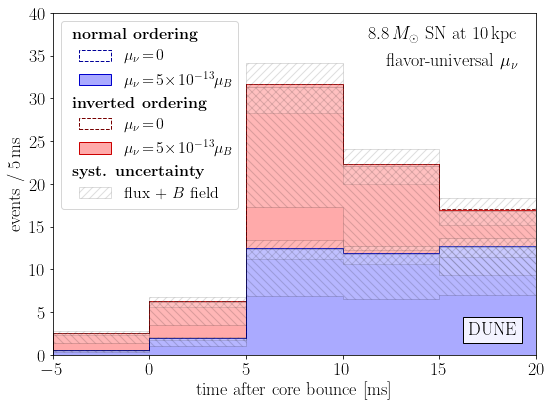

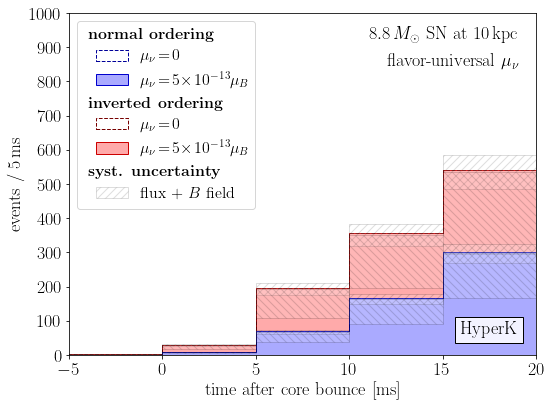

In [50]:
# plot event rates
def repeat_last(x):
    return x[list(range(len(x))) + [-1]]

bin_edges   = np.linspace(-5e-3, 2e-2, 6)  # time bins [sec]
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
exp_labels = { 'DUNE': 'DUNE', 'HK': 'HyperK' }
for exp in ['DUNE','HK']:
    fig, ax = plt.subplots()
    fig.set_size_inches(8,6)

    hist_nomu_NH = np.sum(rates_NH_0[exp,'nu','nomu'] + rates_NH_0[exp,'nubar','nomu'], axis=0)
    hist_mu_NH   = np.sum(rates_NH_0[exp,'nu','mu']   + rates_NH_0[exp,'nubar','mu'],   axis=0)
    hist_nomu_IH = np.sum(rates_IH_0[exp,'nu','nomu'] + rates_IH_0[exp,'nubar','nomu'], axis=0)
    hist_mu_IH   = np.sum(rates_IH_0[exp,'nu','mu']   + rates_IH_0[exp,'nubar','mu'],   axis=0)
    
    hist_nomu_NH_max = np.sum(rates_NH_max[exp,'nu','nomu'] + rates_NH_max[exp,'nubar','nomu'], axis=0)
    hist_mu_NH_max   = np.sum(rates_NH_max[exp,'nu','mu']   + rates_NH_max[exp,'nubar','mu'],   axis=0)
    hist_nomu_IH_max = np.sum(rates_IH_max[exp,'nu','nomu'] + rates_IH_max[exp,'nubar','nomu'], axis=0)
    hist_mu_IH_max   = np.sum(rates_IH_max[exp,'nu','mu']   + rates_IH_max[exp,'nubar','mu'],   axis=0)
    
    hist_nomu_NH_min = np.sum(rates_NH_min[exp,'nu','nomu'] + rates_NH_min[exp,'nubar','nomu'], axis=0)
    hist_mu_NH_min   = np.sum(rates_NH_min[exp,'nu','mu']   + rates_NH_min[exp,'nubar','mu'],   axis=0)
    hist_nomu_IH_min = np.sum(rates_IH_min[exp,'nu','nomu'] + rates_IH_min[exp,'nubar','nomu'], axis=0)
    hist_mu_IH_min   = np.sum(rates_IH_min[exp,'nu','mu']   + rates_IH_min[exp,'nubar','mu'],   axis=0)
    
    plot_nomu_IH = ax.hist(bin_centers*1e3, bins=bin_edges*1e3, weights=hist_nomu_IH,
                           histtype='step', color='#770000', ls='--')[2][0]
#    plot_err = \
#    ax.fill_between(bin_edges*1e3, repeat_last(hist_nomu_IH_min), repeat_last(hist_nomu_IH_max),
#                    step='post', hatch='///', color='#77000022', ec='#77000055', zorder=2.5)
    plot_err = \
    ax.fill_between(bin_edges*1e3, repeat_last(hist_nomu_IH_min), repeat_last(hist_nomu_IH_max),
                    step='post', hatch='///', color='#ffffff22', ec='#00000022', zorder=2.5)

    plot_mu_IH   = ax.hist(bin_centers*1e3, bins=bin_edges*1e3, weights=hist_mu_IH,
                           histtype='stepfilled', color='#ffaaaa', ec='#cc0000')[2][0]
#    ax.fill_between(bin_edges*1e3, repeat_last(hist_mu_IH_min),   repeat_last(hist_mu_IH_max),
#                    step='post', hatch='\\\\\\', color='#cc000022', ec='#cc000055', zorder=2.5)
    ax.fill_between(bin_edges*1e3, repeat_last(hist_mu_IH_min),   repeat_last(hist_mu_IH_max),
                    step='post', hatch='\\\\\\', color='white', ec='black', alpha=0.15, zorder=2.5)

    plot_nomu_NH = ax.hist(bin_centers*1e3, bins=bin_edges*1e3, weights=hist_nomu_NH,
                           histtype='step', color='#000099', ls='--')[2][0]
#    ax.fill_between(bin_edges*1e3, repeat_last(hist_nomu_NH_min), repeat_last(hist_nomu_NH_max),
#                    step='post', hatch='///', color='#00009922', ec='#00009955', zorder=2.5)
    ax.fill_between(bin_edges*1e3, repeat_last(hist_nomu_NH_min), repeat_last(hist_nomu_NH_max),
                    step='post', hatch='///', color='white', ec='black', alpha=0.15, zorder=2.5)

    plot_mu_NH   = ax.hist(bin_centers*1e3, bins=bin_edges*1e3, weights=hist_mu_NH,
                           histtype='stepfilled', color='#aaaaff', ec='#0000cc')[2][0]
#    ax.fill_between(bin_edges*1e3, repeat_last(hist_mu_NH_min),   repeat_last(hist_mu_NH_max),
#                    step='post', hatch='\\\\\\', color='#0000cc22', ec='#0000cc55', zorder=2.5)
    ax.fill_between(bin_edges*1e3, repeat_last(hist_mu_NH_min),   repeat_last(hist_mu_NH_max),
                    step='post', hatch='\\\\\\', color='white', ec='black', alpha=0.15, zorder=2.5)

    legend_title_proxy = matplotlib.patches.Rectangle((0,0), 0, 0, color='w')
    leg = ax.legend([legend_title_proxy, plot_nomu_NH, plot_mu_NH,
                     legend_title_proxy, plot_nomu_IH, plot_mu_IH,
                     legend_title_proxy, plot_err],
                    ['\\bf normal ordering',
                       '$\\mu_\\nu \\! = \\! 0$', 
                       '$\\mu_\\nu \\! = \\! {:d} \\! \\times \\! 10^{{-13}} \\mu_B$'.format(int(mu0/(1e-13*mu_b))),
                     '\\bf inverted ordering',
                       '$\\mu_\\nu \\! = \\! 0$',
                       '$\\mu_\\nu \\! = \\! {:d} \\! \\times \\! 10^{{-13}} \\mu_B$'.format(int(mu0/(1e-13*mu_b))),
                     '\\bf syst. uncertainty', 'flux + $B$ field'], loc='upper left', fontsize=16)
    for item, label in zip(leg.legendHandles, leg.texts): # move legend titles to the left
        item.set_x(20)
        label.set_position((20,0))
        if re.match('.*ordering|.*uncertainty', label._text):
            width = item.get_window_extent(fig.canvas.get_renderer()).width
            label.set_ha('left')
            label.set_position((-width,0))
#        if re.match('10.*', label._text):
#            item.set_y(-10)
#            label.set_position((30,-8))
    leg._legend_box.set_width(165.)
    leg._legend_box.set_height(175.)

    ax.set_xlim(-5, 20)
    ax.xaxis.set_ticks(np.arange(-5, 21, 5))
    if exp == 'HK':
        ax.set_ylim(0,400)
        ax.yaxis.set_ticks(np.arange(0, 1001, 100))
    elif exp == 'DUNE':
        ax.set_ylim(0, 40)
        ax.yaxis.set_ticks(np.arange(0, 41, 5))
    ax.set_ylabel('events / 5\,ms')
    ax.set_xlabel('time after core bounce [ms]')
#    ax.tick_params(axis='both', which='both', labelsize=12)
    plt.tight_layout()
    plt.annotate(exp_labels[exp], (0.96,0.05), xycoords='axes fraction',
                 ha='right', va='bottom',
                 bbox=dict(boxstyle='square', fc='#ffffffdd', ec='black'))
    plt.annotate(r'$8.8\,M_\odot$ SN at 10\,kpc',
                 (0.96,0.96), xycoords='axes fraction', ha='right', va='top')
    plt.annotate(r'flavor-universal $\mu_\nu$',
                 (0.96,0.88), xycoords='axes fraction', ha='right', va='top')
    plt.savefig('{:s}-los{:.2f}.pdf'.format(exp, theta_los/np.pi))
    plt.show()


### Supernova Neutrinos – $\chi^2$ Plots -- OLD

In [ ]:
# generate data for chi^2 plot
#mu_max    = 3.9e-13 * mu_b
mu_min    = 1e-13 * mu_b
#mu_max    = 1.2e-12 * mu_b
mu_max    = 1e-11
#mu_table  = np.linspace(0, mu_max, 50)
mu_table  = np.logspace(np.log10(mu_min/mu_b), np.log10(mu_max/mu_b), 51) * mu_b
l0        = 0.01                     # nominal outer turbulence scale [kpc]
B0        = 2.                       # nominal B field strength [muG]
p         = neutrino_propagator(Bturb=B0, outer_scale=l0,
                                mu_range=np.array([0] + list(mu_table[::2]) + [1e-11*mu_b]))
chi_DUNE  = {}
chi_HK    = {}
for mh in ['NH','IH']:
    for s, M in zip(['muonly','allflavors'], [M_mu_only, M_all_flavors]):
        if __name__ == '__main__':
            with pathos.pools.ProcessPool() as pool:
                pool.restart()  # not sure why this is necessary, but without it,
                                # the code sometimes doesn't "forget" old results
                chi_DUNE[mh,s] = np.array(pool.map(lambda mu: p.propagate_sn_neutrinos(mu*M, mh=mh, a_norm=0., dn=True,  hk=False), mu_table))
                chi_HK[mh,s]   = np.array(pool.map(lambda mu: p.propagate_sn_neutrinos(mu*M, mh=mh, a_norm=0., dn=False, hk=True),  mu_table))
#        chi_DUNE = np.array([ p.propagate_sn_neutrinos(mu*M, mh=mh, a_norm=0., dn=True,  hk=False) for mu in mu_table ])
#        chi_HK   = np.array([ p.propagate_sn_neutrinos(mu*M, mh=mh, a_norm=0., dn=False, hk=True)  for mu in mu_table ])

for mh in ['NH','IH']:
    for s in ['muonly','allflavors']:
        np.savetxt('data/chi_{:s}_{:s}_DUNE.txt'.format(s, mh), np.array([mu_table, chi_DUNE[mh,s]]).T)

        np.savetxt('data/chi_{:s}_{:s}_HK.txt'.format(s, mh),   np.array([mu_table, chi_HK[mh,s]]).T)

In [ ]:
# generate data for uncertainty bands
n_samples      = 50                                     # number of random B field configurations
l_table        = 10**rnd.uniform(-3,-1,size=n_samples)  # outer turbulence scale [kpc]
B_table        = rnd.normal(scale=5,   size=n_samples)  # magnetic field strength [muG]    
a_table        = rnd.normal(scale=0.1, size=n_samples)  # flux normalization bias
chi_table_DUNE = {}
chi_table_HK   = {}
for j, l, B, a in zip(range(n_samples), l_table, B_table, a_table):
    np.savetxt('chi2.log', [j,l,B,a])
    p.generate_B_field_gal(Bturb=B, outer_scale=l, random_B_coh=True, cpus=4,
                           mu_range=np.array([0] + list(mu_table[::2]) + [1e-11*mu_b]))
    for mh in ['NH','IH']:
        for s, M in zip(['muonly','allflavors'], [M_mu_only, M_all_flavors]):
            if not (mh,s) in chi_table_DUNE.keys():
                chi_table_DUNE[mh,s] = []
                chi_table_HK[mh,s]   = []
            if __name__ == '__main__':
                with pathos.pools.ProcessPool() as pool:
                    pool.restart()  # not sure why this is necessary, but without it,
                                    # the code sometimes doesn't "forget" old results
                    chi_table_DUNE[mh,s].append(np.array(pool.map(lambda mu: p.propagate_sn_neutrinos(mu*M, mh=mh, a_norm=a, dn=True,  hk=False), mu_table)))
                    chi_table_HK[mh,s].append(  np.array(pool.map(lambda mu: p.propagate_sn_neutrinos(mu*M, mh=mh, a_norm=a, dn=False, hk=True),  mu_table))) 
#            chi_table_DUNE[mh,s].append( np.array([ p.propagate_sn_neutrinos(mu*M, mh=mh, a_norm=a, dn=True,  hk=False) for mu in mu_table ]))
#            chi_table_HK[mh,s].append(   np.array([ p.propagate_sn_neutrinos(mu*M, mh=mh, a_norm=a, dn=False, hk=True)  for mu in mu_table ]))        
            
for mh in ['NH','IH']:
    for s, M in zip(['muonly','allflavors'], [M_mu_only, M_all_flavors]):
        np.savetxt('data/chi_{:s}_{:s}_DUNE-samples.txt'.format(s, mh), np.array([mu_table] + chi_table_DUNE[mh,s]).T)
        np.savetxt('data/chi_{:s}_{:s}_HK-samples.txt'  .format(s, mh), np.array([mu_table] + chi_table_HK[mh,s]).T)

In [ ]:
chi0      = {}
chi_table = {}
for mh in ['NH','IH']:
    for s, M in zip(['muonly','allflavors'], [M_mu_only, M_all_flavors]):
        for exp in ['DUNE','HK']:
            chi0[s,mh,exp]      = np.loadtxt('data/chi_{:s}_{:s}_{:s}.txt'.format(s, mh, exp))
            chi_table[s,mh,exp] = np.loadtxt('data/chi_{:s}_{:s}_{:s}-samples.txt'.format(s, mh, exp))
mu_table = chi0['allflavors','NH','DUNE'][:,0]

q = 0.5 * 0.317311  # quantile we are interested in for the error bands - this is for 1\sigma
exp_labels = { 'DUNE': 'DUNE', 'HK': 'HyperK' }
for exp in ['DUNE','HK']:
    fig, ax = plt.subplots()
    fig.set_size_inches(8,6)
    plot_allflavors_NH,     = ax.plot(mu_table/mu_b, chi0['allflavors','NH',exp][:,1], c='#0000cc', lw=2)
    plot_allflavors_err_NH  = ax.fill_between(chi_table['allflavors','NH',exp][:,0]/mu_b,
                                              np.quantile(chi_table['allflavors','NH',exp][:,1:], q,   axis=1),
                                              np.quantile(chi_table['allflavors','NH',exp][:,1:], 1-q, axis=1),
                                              color='#aaaaff55', ec='#0000cc55', lw=0.5)
    plot_allflavors_IH,     = ax.plot(mu_table/mu_b, chi0['allflavors','IH',exp][:,1], c='#cc0000', lw=2)
    plot_allflavors_err_IH  = ax.fill_between(chi_table['allflavors','IH',exp][:,0]/mu_b,
                                              np.quantile(chi_table['allflavors','IH',exp][:,1:], q,   axis=1),
                                              np.quantile(chi_table['allflavors','IH',exp][:,1:], 1-q, axis=1),
                                              color='#ffaaaa55', ec='#cc000055', lw=0.5)
    plot_muonly_NH,         = ax.plot(mu_table/mu_b, chi0['muonly','NH',exp][:,1],     c='#0000cc', ls=':')
    plot_muonly_err_NH      = ax.fill_between(chi_table['muonly','NH',exp][:,0]/mu_b,
                                              np.quantile(chi_table['muonly','NH',exp][:,1:], q,   axis=1),
                                              np.quantile(chi_table['muonly','NH',exp][:,1:], 1-q, axis=1),
                                              color='#aaaaff55', ec='#0000cc55', lw=0.5)
    plot_muonly_IH,         = ax.plot(mu_table/mu_b, chi0['muonly','IH',exp][:,1],     c='#cc0000', ls=':')
    plot_muonly_err_IH      = ax.fill_between(chi_table['muonly','IH',exp][:,0]/mu_b,
                                              np.quantile(chi_table['muonly','IH',exp][:,1:], q,   axis=1),
                                              np.quantile(chi_table['muonly','IH',exp][:,1:], 1-q, axis=1),
                                              color='#ffaaaa55', ec='#cc000055', lw=0.5)

    ax.set_xlim(min(mu_table)/mu_b, max(mu_table)/mu_b)
    ax.set_ylim(0, 10)
    ax.set_xscale('log')
#    ax.xaxis.set_ticks(np.arange(0, 1.001*mu_max/mu_b, .5e-13))
#    ax.yaxis.set_ticks(np.arange(0, 10.0001, 1))
#    ax.grid()
    ax.hlines(2.71, 0, mu_max/mu_b, color='k', ls='--', lw=1)
    ax.hlines(3.84, 0, mu_max/mu_b, color='k', ls='--', lw=1)
    ax.hlines(6.63, 0, mu_max/mu_b, color='k', ls='--', lw=1)
    ax.annotate(r'$95 \%$ C.L.', (0.05e-13, 3.95), bbox=dict(boxstyle='square', pad=0, fc='#ffffffdd', ec='none'))
    ax.annotate(r'$99 \%$ C.L.', (0.05e-13, 6.75), bbox=dict(boxstyle='square', pad=0, fc='#ffffffdd', ec='none'))
    ax.annotate(r'$90 \%$ C.L.', (0.05e-13, 2.85), bbox=dict(boxstyle='square', pad=0, fc='#ffffffdd', ec='none'))
    ax.set_ylabel(r'$\chi^2$')
    ax.set_xlabel(r'neutrino magnetic moment $\mu_\nu$ [$\mu_B$]')
    s = (r'Combined analysis of DUNE and Hyper-K setting $\\mu_e = \\mu_\\mu = \\mu_\\tau = \\mu_\\nu$')

    legend_title_proxy = matplotlib.patches.Rectangle((0,0), 0, 0, color='#00000000')
    leg = ax.legend([legend_title_proxy, (plot_allflavors_NH,plot_allflavors_err_NH), (plot_muonly_NH,plot_muonly_err_NH),
                     legend_title_proxy, (plot_allflavors_IH,plot_allflavors_err_IH), (plot_muonly_IH,plot_muonly_err_IH)],
                    [r'\bf normal ordering',  r'flavor-universal $\mu_\nu$', r'$\mu_\nu \neq 0$ for $\nu_\mu$ only',
                     r'\bf inverted ordering',r'flavor-universal $\mu_\nu$', r'$\mu_\nu \neq 0$ for $\nu_\mu$ only'],
                    handler_map={tuple: matplotlib.legend_handler.HandlerTuple()},
                    loc='upper right', framealpha=.9)
    
    def set_legend_handle_pos(packer, x):
        for p in packer.get_children():
            if isinstance(p, matplotlib.offsetbox.OffsetBox):
                set_legend_handle_pos(p, x)
            elif isinstance(p, matplotlib.patches.Rectangle):
                p.set_x(x)
            elif isinstance(p, matplotlib.lines.Line2D):
                p.set_xdata(np.array(p.get_xdata()) + 20)            
    set_legend_handle_pos(leg._legend_box, 20)
    for item, label in zip(leg.legendHandles, leg.texts): # move legend titles to the left
        if re.match('.*ordering', label._text):  # headings
            width = item.get_window_extent(fig.canvas.get_renderer()).width
            label.set_ha('left')
            label.set_position((-1.3*width,0))
        else:                                    # genuine legend entries
            label.set_position((20,0))
        leg._legend_box.set_width(195)
    plt.annotate(exp_labels[exp], (0.96,0.05), xycoords='axes fraction',
                 ha='right', va='bottom',
                 bbox=dict(boxstyle='square', fc='#ffffffdd', ec='black'))
    plt.annotate(r'$8.8\,M_\odot$ SN at 10\,kpc',
                 (0.02,0.96), xycoords='axes fraction', ha='left', va='top', backgroundcolor='#ffffffaa')
    plt.tight_layout()
    plt.savefig('chi2-vs-mu-{:s}.pdf'.format(exp))
    plt.show()

### Supernova Neutrinos – $\chi^2$ Plots

In [4]:
# generate data for chi^2 plot
mu_min          = 1e-13 * mu_b
#mu_max          = 1.2e-12 * mu_b
mu_max          = 1e-11 * mu_b
mu_table        = np.logspace(np.log10(mu_min/mu_b), np.log10(mu_max/mu_b), 51) * mu_b
d               = 10*kpc                   # distance to the SN
theta_los       = np.pi/4                  # direction of line of sight
l0              = 0.01                     # nominal outer turbulence scale [kpc]
B0              = 2.                       # nominal B field strength [muG]
sigma_l         = 0.05                     # systematic uncertainty in the outer turbulence scale [kpc]
sigma_B         = 2.                       #                        in the B field [muG]
sigma_a         = 0.1                      #                        in the flux normalization

n_samples       = 60                       # number of random B field configurations
l_table         = np.array([l0] + list(10**rnd.uniform(-3,-1,size=n_samples))) # outer turbulence scale [kpc]
B_table         = np.array([B0] + list(rnd.normal(scale=5,size=n_samples)))    # magnetic field strength [muG]    
a_table         = np.array([0.] + list(rnd.normal(scale=0.1,size=n_samples)))  # flux normalization bias
rate_table_DUNE = {}  # structure of these tables:
rate_table_HK   = {}  #   ((mh,s), nuisance param. point, magn. moment, (exp,nu/nubar,mu/nomu), flavor, time)
p               = neutrino_propagator(d=d, theta_los=theta_los, Bturb=B0, outer_scale=l0, mu_range=np.array([0]))
                      # use dummy mu_range here - the real one will be used below
for j, l, B, a in zip(range(n_samples+1), l_table, B_table, a_table):
    print(j)
    np.savetxt('chi2.log', [j,l,B,a])
    p.generate_B_field_gal(d=d, theta_los=theta_los, Bturb=B, outer_scale=l, random_B_coh=True, cpus=8,
                           mu_range=np.array([0] + list(mu_table[::2]) + [1.1*mu_max]))
    for mh in ['NH','IH']:
        for s, M in zip(['muonly','allflavors'], [M_mu_only, M_all_flavors]):
            if not (mh,s) in rate_table_DUNE.keys():
                rate_table_DUNE[mh,s] = []
                rate_table_HK[mh,s]   = []
            if __name__ == '__main__':
                with pathos.pools.ProcessPool() as pool:
                    pool.restart()  # not sure why this is necessary, but without it,
                                    # the code sometimes doesn't "forget" old results
                    func_DUNE  = lambda mu: p.propagate_sn_neutrinos(mu*M, mh=mh, a_norm=a,
                                                                     dn=True, hk=False, return_rates=True)[1]
                    func_HK    = lambda mu: p.propagate_sn_neutrinos(mu*M, mh=mh, a_norm=a,
                                                                     dn=False, hk=True, return_rates=True)[1]
                    rates_DUNE = np.array(pool.map(func_DUNE, mu_table))
                    rates_HK   = np.array(pool.map(func_HK,   mu_table))
                    rate_table_DUNE[mh,s].append(rates_DUNE)
                    rate_table_HK[mh,s].append(rates_HK)

            # we write results to disk intermittently in case something goes wrong
            with open('data/SN_rates-los{:.2f}.dat'.format(theta_los/np.pi), 'wb') as f:
                pickle.dump((mu_table, l_table, B_table, a_table, rate_table_DUNE, rate_table_HK), f)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [7]:
glob.glob('data/SN_rate*.dat')

['data/SN_rates-los0.25.dat',
 'data/SN_rates.dat',
 'data/SN_rates-lowres.dat',
 'data/SN_rates-los0.00.dat']

In [8]:
#mode = 'sensitivity'   # compute sensitivity
mode = 'discovery'     # compute discovery potential

def chi2_gauss(true_rate, test_rate):
    """compute Gaussian chi^2 (in a fully vecorizable way)"""
    return (true_rate - test_rate)**2 / test_rate
    
def chi2_poisson(true_rate, test_rate):
    """compute Poissonian chi^2 (in a fully vecorizable way)"""
    return 2. * np.where(true_rate <= 0,
                         np.abs(true_rate - test_rate),
                         np.where(test_rate <= 0,
                                  1e00,
                                  test_rate - true_rate + true_rate * np.log(true_rate/test_rate)))

rate_table  = {}
chi2_table  = {}
with open('data/SN_rates-los0.00.dat', 'rb') as f:
    mu_table, l_table, B_table, a_table, rate_table['DUNE'], rate_table['HK'] = pickle.load(f)
# with open('data/rates_DUNE.dat', 'rb') as f:
#     rate_table['DUNE'] = pickle.load(f)
# with open('data/rates_HK.dat', 'rb') as f:
#     rate_table['HK'] = pickle.load(f)
# with open('data/rates_mu_table.dat', 'rb') as f:
#     mu_table = pickle.load(f)
for mh in ['NH','IH']:
    for s, M in zip(['muonly','allflavors'], [M_mu_only, M_all_flavors]):
        for exp in ['DUNE','HK']:
            # DISCOVERY POTENTIAL
            if mode == 'discovery':
                # the structure of the following is
                # (true nuisance params, test nuisance params, test value of mu)
                this_chi2 = np.array([ [ [
                                # DISCOVERY POTENTIAL
                                # inner sum over flavors, outer sum over time bins
                                np.sum(chi2_gauss(np.sum(r_true[j][exp,'nu','mu'] 
                                                         + r_true[j][exp,'nu','mu'], axis=0),
                                                  np.sum(r_test[0][exp,'nu','nomu']
                                                         + r_test[0][exp,'nu','nomu'], axis=0)))
                                    + (l - l0)**2 / sigma_l**2          # constraints on nuisance parameters
                                    + (B - B0)**2 / sigma_B**2
                                    + a**2 / sigma_a**2
                                for j in range(len(r_test)) ]           # loop over test values of mu
                                for r_test, l, B, a in zip(rate_table[exp][mh,s], l_table, B_table, a_table) ]
                                                                        # loop over "fitted" nuisance parameter values
                                for r_true in rate_table[exp][mh,s] ])  # loop over "true" nuisance parameter values

            # SENSITIVITY
            elif mode == 'sensitivity':
                # the structure of the following is
                # (true nuisance params, test nuisance params, test value of mu)
                this_chi2 = np.array([ [ [
                                # SENSITIVITY               
                                # inner sum over flavors, outer sum over time bins
                                np.sum(chi2_gauss(np.sum(r_true[0][exp,'nu','nomu'] 
                                                         + r_true[0][exp,'nu','nomu'], axis=0),
                                                  np.sum(r_test[j][exp,'nu','mu']
                                                         + r_test[j][exp,'nu','mu'], axis=0)))
                                    + (l - l0)**2 / sigma_l**2          # constraints on nuisance parameters
                                    + (B - B0)**2 / sigma_B**2
                                    + a**2 / sigma_a**2
                                for j in range(len(r_test)) ]           # loop over test values of mu
                                for r_test, l, B, a in zip(rate_table[exp][mh,s], l_table, B_table, a_table) ]
                                                                        # loop over "fitted" nuisance parameter values
                                for r_true in rate_table[exp][mh,s] ])  # loop over "true" nuisance parameter values

            # minimize over test values
            # the structure of the following is
            # (true nuisance params, test value of mu)
            chi2_table[s,mh,exp] = np.amin(this_chi2, axis=1)


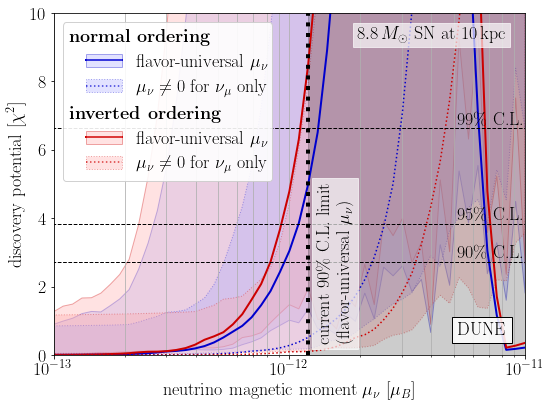

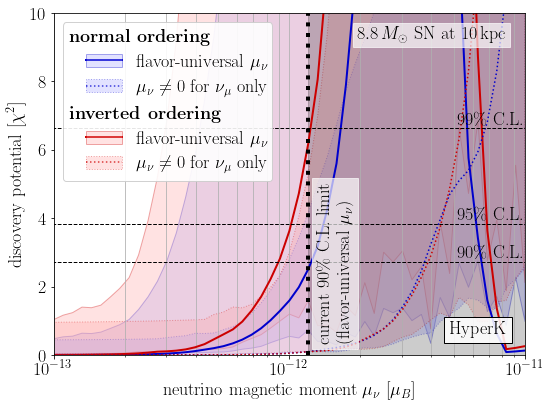

In [9]:
q = 0.5 * 0.317311  # quantile we are interested in for the error bands - this is for 1\sigma
exp_labels = { 'DUNE': 'DUNE', 'HK': 'HyperK' }
for exp in ['DUNE','HK']:
    fig, ax = plt.subplots()
    fig.set_size_inches(8,6)
    plot_allflavors_NH,     = ax.plot(mu_table/mu_b, chi2_table['allflavors','NH',exp][0], c='#0000cc', lw=2)
    plot_allflavors_err_NH  = ax.fill_between(mu_table/mu_b,
                                              np.quantile(chi2_table['allflavors','NH',exp], q,   axis=0),
                                              np.quantile(chi2_table['allflavors','NH',exp], 1-q, axis=0),
                                              color='#aaaaff55', ec='#0000cc55', lw=1)
    plot_allflavors_IH,     = ax.plot(mu_table/mu_b, chi2_table['allflavors','IH',exp][0], c='#cc0000', lw=2)
    plot_allflavors_err_IH  = ax.fill_between(mu_table/mu_b,
                                              np.quantile(chi2_table['allflavors','IH',exp], q,   axis=0),
                                              np.quantile(chi2_table['allflavors','IH',exp], 1-q, axis=0),
                                              color='#ffaaaa55', ec='#cc000055', lw=1)
    plot_muonly_NH,         = ax.plot(mu_table/mu_b, chi2_table['muonly','NH',exp][0],     c='#0000cc', ls=':')
    plot_muonly_err_NH      = ax.fill_between(mu_table/mu_b,
                                              np.quantile(chi2_table['muonly','NH',exp], q,   axis=0),
                                              np.quantile(chi2_table['muonly','NH',exp], 1-q, axis=0),
                                              color='#aaaaff55', ec='#0000cc55', lw=1, ls=':')
    plot_muonly_IH,         = ax.plot(mu_table/mu_b, chi2_table['muonly','IH',exp][0],     c='#cc0000', ls=':')
    plot_muonly_err_IH      = ax.fill_between(mu_table/mu_b,
                                              np.quantile(chi2_table['muonly','IH',exp], q,   axis=0),
                                              np.quantile(chi2_table['muonly','IH',exp], 1-q, axis=0),
                                              color='#ffaaaa55', ec='#cc000055', lw=1, ls=':')

    # mark C.L. thresholds
    ax.hlines(2.71, 0, mu_table[-1]/mu_b, color='k', ls='--', lw=1)
    ax.hlines(3.84, 0, mu_table[-1]/mu_b, color='k', ls='--', lw=1)
    ax.hlines(6.63, 0, mu_table[-1]/mu_b, color='k', ls='--', lw=1)
    ax.annotate(r'$95 \%$ C.L.', (0.99*max(mu_table/mu_b), 3.95), ha='right')
    ax.annotate(r'$99 \%$ C.L.', (0.99*max(mu_table/mu_b), 6.75), ha='right')
    ax.annotate(r'$90 \%$ C.L.', (0.99*max(mu_table/mu_b), 2.85), ha='right')

    # legend
    legend_title_proxy = matplotlib.patches.Rectangle((0,0), 0, 0, color='#00000000')
    leg = ax.legend([legend_title_proxy, (plot_allflavors_NH,plot_allflavors_err_NH), (plot_muonly_NH,plot_muonly_err_NH),
                     legend_title_proxy, (plot_allflavors_IH,plot_allflavors_err_IH), (plot_muonly_IH,plot_muonly_err_IH)],
                    [r'\bf normal ordering',  r'flavor-universal $\mu_\nu$', r'$\mu_\nu \neq 0$ for $\nu_\mu$ only',
                     r'\bf inverted ordering',r'flavor-universal $\mu_\nu$', r'$\mu_\nu \neq 0$ for $\nu_\mu$ only'],
                    handler_map={tuple: matplotlib.legend_handler.HandlerTuple()},
                    loc='upper left', framealpha=.9)
    
    def set_legend_handle_pos(packer, x):
        for p in packer.get_children():
            if isinstance(p, matplotlib.offsetbox.OffsetBox):
                set_legend_handle_pos(p, x)
            elif isinstance(p, matplotlib.patches.Rectangle):
                p.set_x(x)
            elif isinstance(p, matplotlib.lines.Line2D):
                p.set_xdata(np.array(p.get_xdata()) + 20)            
    set_legend_handle_pos(leg._legend_box, 20)
    for item, label in zip(leg.legendHandles, leg.texts): # move legend titles to the left
        if re.match('.*ordering', label._text):  # headings
            width = item.get_window_extent(fig.canvas.get_renderer()).width
            label.set_ha('left')
            label.set_position((-1.3*width,0))
        else:                                    # genuine legend entries
            label.set_position((20,0))
        leg._legend_box.set_width(195)
        
    # other labels
    plt.annotate(exp_labels[exp], (0.96,0.05), xycoords='axes fraction',
                 ha='right', va='bottom',
                 bbox=dict(boxstyle='square', fc='#ffffffdd', ec='black'))
    plt.annotate(r'$8.8\,M_\odot$ SN at 10\,kpc',
                 (0.96,0.96), xycoords='axes fraction', ha='right', va='top', backgroundcolor='#ffffffaa')
    
    ax.vlines(1.2e-12, 0, 20, colors='k', ls=':', lw=4)
    ax.axvspan(1.2e-12, 1e-10, color='#00000033')
    plt.annotate(r'\parbox{10cm}{current 90\% C.L. limit\\[-0.1cm](flavor-universal $\mu_\nu$)}', (1.3e-12,0.3),
                 rotation=90, color='k', ha='left', va='bottom', backgroundcolor='#ffffffaa')
    
    # general plot / axis properties
    if mode == 'sensitivity':
        ax.set_ylabel(r'sensitivity [$\chi^2$]')
    elif mode == 'discovery':
        ax.set_ylabel(r'discovery potential [$\chi^2$]')
    ax.set_xlim(min(mu_table)/mu_b, max(mu_table)/mu_b)
    ax.set_ylim(0, 10)
    ax.set_xscale('log')
#    ax.xaxis.set_ticks(np.arange(0, 1.001*mu_table[-1]/mu_b, .5e-13))
#    ax.yaxis.set_ticks(np.arange(0, 10.0001, 1))
    ax.grid(axis='x', which='both')
    ax.set_xlabel(r'neutrino magnetic moment $\mu_\nu$ [$\mu_B$]')
    plt.tight_layout()
    
    plt.savefig('chi2-vs-mu-{:s}.pdf'.format(exp))
    plt.show()

### Constraints Summary Plot

NameError: name 'mc' is not defined

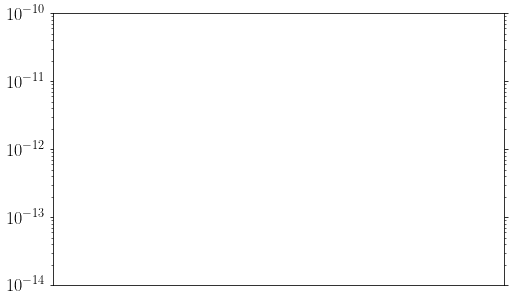

In [9]:
limits = np.loadtxt('limits/Current_Limits.csv', usecols=(1,))
mu_NO  = np.loadtxt('limits/nu_mu_limit_NO.txt')*1e-13
mu_IO  = np.loadtxt('limits/nu_mu_limit_IO.txt')*1e-13
nus_NO = np.loadtxt('limits/nus_limit_NO.txt')*1e-13
nus_IO = np.loadtxt('limits/nus_limit_IO.txt')*1e-13
mu_limits = [min(mu_NO), min(mu_IO), min(nus_NO), min(nus_IO)]

fig, ax = plt.subplots(figsize=(((1+np.sqrt(5))/2 * 5), 5))

ax.set_yscale('log')
ax.set_ylim(1e-14, 1e-10)
ax.tick_params(
    axis='x',
    bottom=False,
    labelbottom=False)
ax.tick_params(
    axis='y',
    which='both',
    right=True)
lines1 = [[(9, (n*np.pi/0.4039+1)*max(nus_NO)), (9, ((n+1)*np.pi/0.4039-1)*max(nus_NO))] for n in range(1500)]
lines2 = [[(9, (n*np.pi/0.4039+1)*min(nus_NO)), (9, ((n+1)*np.pi/0.4039-1)*min(nus_NO))] for n in range(1500)]
lines3 = [[(10, (n*np.pi/0.4039+1)*max(nus_IO)), (10, ((n+1)*np.pi/0.4039-1)*max(nus_IO))] for n in range(1500)]
lines4 = [[(10, (n*np.pi/0.4039+1)*min(nus_IO)), (10, ((n+1)*np.pi/0.4039-1)*min(nus_IO))] for n in range(1500)]
lines1 = np.reshape(np.array(lines1), (1500, 2, 2))
lines2 = np.reshape(np.array(lines2), (1500, 2, 2))
lines3 = np.reshape(np.array(lines3), (1500, 2, 2))
lines4 = np.reshape(np.array(lines4), (1500, 2, 2))
lc1 = matplotlib.collections.LineCollection(lines1, colors='b', linewidths=np.sqrt(500), capstyle="butt", alpha=0.5)
lc2 = matplotlib.collections.LineCollection(lines2, colors='b', linewidths=np.sqrt(500), capstyle="butt", alpha=0.5)
lc3 = matplotlib.collections.LineCollection(lines3, colors='b', linewidths=np.sqrt(500), capstyle="butt", alpha=0.5)
lc4 = matplotlib.collections.LineCollection(lines4, colors='b', linewidths=np.sqrt(500), capstyle="butt", alpha=0.5)
ax.add_collection(lc2)
ax.add_collection(lc1)
ax.add_collection(lc3)
ax.add_collection(lc4)
for i in range(len(limits)):
    ax.arrow(i, limits[i], 0, -0.2*limits[i], head_length=0.05*limits[i], width = 0.02,
             head_width=0.15, length_includes_head=True, fc="gray", ec="gray")
for i in range(int(len(mu_limits)/2)):
    ax.arrow(i+len(limits), mu_limits[i], 0, -0.2*mu_limits[i], head_length=0.05*mu_limits[i],
             width = 0.02, head_width=0.15, length_includes_head=True, fc="b", ec="b")
    ax.arrow(i+2+len(limits), mu_limits[i+2], 0, -0.2*mu_limits[i+2], head_length=0.05*mu_limits[i+2],
             width = 0.02, head_width=0.15, length_includes_head=True, fc="r", ec="r")
ax.plot([7, 7], [min(mu_NO), max(mu_NO)], linewidth=np.sqrt(500), solid_capstyle="butt", c="b", alpha=0.5)
ax.plot([8, 8], [min(mu_IO), max(mu_IO)], linewidth=np.sqrt(500), solid_capstyle="butt", c="b", alpha=0.5)
# ax.plot([9, 9], [min(nus_NO), max(nus_NO)], linewidth=np.sqrt(500), solid_capstyle="butt", c="c")
# ax.plot([10, 10], [min(nus_IO), max(nus_IO)], linewidth=np.sqrt(500), solid_capstyle="butt", c="c")
ax.scatter(range(len(limits)), limits, s=500, marker='_', color="gray")
ax.scatter(len(limits)+np.arange(len(mu_limits)), mu_limits, s=500, marker='_', color=["b", "b", "r", "r"])
ax.set_ylabel(r'neutrino magnetic moment $\mu_\nu$ [$\mu_B$]')
ax.text(0, 1.1*limits[0], "White \n dwarfs", color="gray", ha="center", size=11)
ax.text(1, 1.1*limits[1], "Globular \n Cluster", color="gray", ha="center", size=11)
ax.text(2, 1.1*limits[2], "Borexino", color="gray", ha="center", size=11)
ax.text(3, 1.1*limits[3], "Gemma", color="gray", ha="center", size=11)
ax.text(4, 1.1*limits[4], "PandaX-II", color="gray", ha="center", size=11)
ax.text(5, 1.1*limits[5], "XENON1T", color="gray", ha="center", size=11)
ax.text(6, 1.1*limits[6], "XENONnT", color="gray", ha="center", size=11)
ax.text(7, 0.6*mu_limits[0], r'$\nu_\mu$ only (NO)', color="b", ha="center", size=11)
ax.text(8, 0.6*mu_limits[1], r'$\nu_\mu$ only (IO)', color="b", ha="center", size=11)
ax.text(9, 0.6*mu_limits[2], r'$\mu_\nu$''\'s (NO)', color="r", ha="center", size=11)
ax.text(10, 0.6*mu_limits[3], r'$\mu_\nu$''\'s (IO)', color="r", ha="center", size=11)
plt.tight_layout()
plt.grid(axis='y')
#plt.savefig("limits.pdf")
plt.show()

### UHE Neutrinos – Flavor Ratios

In [45]:
fs = np.array([[0, 1, 0], [1, 2, 0]])  # flavor ratios at the source

N         = 20 # FIXME 1000                            # number of random parameter points
Nbs       = 50                   # number of independent random B field configurations
scale     = 'lin'
s         = 'single-source'      # pick one random B field profile for each point
s         = 'multi-source'       # average over random B field profiles
use_cache = False # FIXME                 # store points in file / attempt to read points from file?
if s == 'single-source':
    mu_min    = 0 * mu_b
    mu_max    = 5e-17 * mu_b         # maximal magnetic moment considered in this analysis
elif s == 'multi-source':
    mu_min    = 0 * mu_b
    mu_max    = 1e-14 * mu_b         # maximal magnetic moment considered in this analysis
    
# generate B field profiles
p = neutrino_propagator(mu_range=[0])
p.generate_B_field_extragal(Nbs=Nbs)

In [ ]:
# IceCube limits on flavor ratios (from 1507.03991)
contour1 = np.concatenate((np.flip(np.loadtxt('data/contour.csv'), axis=0),
                           np.loadtxt('data/contour2.csv')[1:]), axis=0)
contour2 = np.loadtxt('data/contour3.csv')
contour3 = np.loadtxt('data/contour4.csv')

# IceCube projected limits (from 2008.04323)
contour8 = np.roll(np.loadtxt('data/8.csv'), 2, axis=1)
contour15 = np.roll(np.loadtxt('data/15.csv'), 2, axis=1)
contour1510 = np.roll(np.loadtxt('data/15+10.csv'), 2, axis=1)

# Parameters for the initial flux of astrophysical neutrinos (taken from 1507.03991)
phi_0 = 6.7
gamma = 2.5
E_min = 25 * TeV
E_max = 2.8 * PeV
h     = np.sqrt(3/4)    # height of ternary plot

def ratios(f_in, M_mu, m, Um):
    """Returns the final flavor ratios"""
    mu = np.linalg.multi_dot([Um.T, M_mu, Um])    # rotation to mass basis
    if s == 'multi-source':
        f_temp = np.array([ [np.dot(f_in, Um[:,j]**2) * p.P_osc_extragal(mu[j,j], idx=l)
                               for j in range(3)] for l in range(Nbs) ])
                    # FIXME why are the off-diagonal elements of mu not included?
        f      = np.array([np.sum(np.dot(f_temp, Um[k,:]**2)) for k in range(3)])
        return f/np.sum(f) # FIXME
    elif s == 'single-source':
        l      = np.random.randint(Nbs)
        f_temp = np.array([np.dot(f_in, Um[:,j]**2) * p.P_osc_extragal(mu[j,j], idx=l)
                               for j in range(3)])
                    # FIXME why are the off-diagonal elements of mu not included?
        f      = np.array([np.dot(f_temp, Um[k,:]**2) for k in range(3)])
        return f/np.sum(f)

def three_to_two(f):
    """Converts coordinates from ternary plot into cartesian ones (three coordinates to two)"""
#    return [[(f[i][1] + 2*f[i][0])/2, f[i][1]*h] for i in range(len(f))]
    return np.array([(f[:,1] + 2*f[:,0])/2, f[:,1]*h]).T

point_0    = np.array([0.31342, 0.34778, 0.33880])

# generate random parameter points
th12_table = np.random.normal(loc=theta12, scale=d_theta12, size=N)
th13_table = np.random.normal(loc=theta13, scale=d_theta13, size=N)
th23_table = np.random.normal(loc=theta23, scale=d_theta23, size=N)
U_table    = np.array([PMNS(th12, th13, th23)[:3,:3]
                 for th12, th13, th23 in zip(th12_table, th13_table, th23_table)])
if scale == 'lin':
    mu_table = np.random.uniform(mu_min, mu_max, size=N)
elif scale == 'log':
    mu_table = 10**np.random.uniform(np.log10(mu_min), np.log10(mu_max), size=N)
else:
    raise ValueError('invalid option: scale={:s}'.format(scale))

# propagate neutrinos for the generated points
# if stored points exist, use them to save time
points = {}
if use_cache and os.path.exists("data/flavor-ratio-{:s}-points_10.dat".format(s)):
    for j in range(1,3):
        for k in ['0','sm','v']:
            points['{:d}{:s}'.format(j,k)] \
                = np.loadtxt("data/flavor-ratio-{:s}-points_{:d}{:s}.dat".format(s,j,k))
else:
    if __name__ == '__main__':
        with pathos.pools.ProcessPool() as pool:
            pool.restart()  # not sure why this is necessary, but without it,
                            # the code sometimes doesn't "forget" old results
            
            # flavor ratios at zero magnetic moment for the nominal values of the oscillation parameters
            U             = PMNS(theta12, theta13, theta23)[:3,:3]
            points['10']  = ratios(fs[0], np.zeros((3,3)), m_nh, U)
            points['20']  = ratios(fs[1], np.zeros((3,3)), m_nh, U)

            # flavor ratios at zero magnetic moment, but including oscillation parameter uncertainties
            points['1sm'] = np.array(pool.map(lambda U: ratios(fs[0], 0*M_mu_only, m_nh, U), U_table))
            points['2sm'] = np.array(pool.map(lambda U: ratios(fs[1], 0*M_mu_only, m_nh, U), U_table))
            
            # flavor ratios for varying magnetic moment and oscillation parameters
            points['1v']  = np.array(pool.map(lambda mu, U: ratios(fs[0], mu*M_mu_only, m_nh, U),
                                              mu_table, U_table))
            points['2v']  = np.array(pool.map(lambda mu, U: ratios(fs[1], mu*M_mu_only, m_nh, U),
                                              mu_table, U_table))
    if use_cache:
        for j in range(1,3):
            for k in ['0','sm','v']:
                np.savetxt("data/flavor-ratio-{:s}-points_{:d}{:s}.dat".format(s,j,k), points['{:d}{:s}'.format(j,k)])
        
# color maps
blues  = plt.get_cmap('Blues')
greens = plt.get_cmap('Greens')
grey   = plt.get_cmap('Greys')
cmbl   = colors.ListedColormap(np.flip(blues(np.linspace(1.0, 0.25, 256)), axis=0))
cmgr   = colors.ListedColormap(np.flip(greens(np.linspace(1.0, 0.25, 256)), axis=0))

for j, cm in zip(range(1,3), [cmbl, cmgr]):
    fig, tax = ternary.figure()
    fig.set_size_inches(7,5)
    ax = tax.get_axes()
    tax.gridlines(multiple=0.1, color='grey')
    tax.boundary()
    tax.set_background_color('white')
    tax.bottom_axis_label("$\\nu_e$", offset=0.03, fontsize=16)
    tax.right_axis_label("$\\nu_{\\mu}$", offset=0.1, fontsize=16)
    tax.left_axis_label("$\\nu_{\\tau}$", offset=0.16, fontsize=16)
    ax.axis('off')
    ax.set_aspect(1)
    tax.ticks(axis='lbr', linewidth=0.5, multiple=0.2, tick_formats="%.1f", offset=0.025, fontsize=16)

    plt1, = ax.plot(np.transpose(three_to_two(contour1))[0], np.transpose(three_to_two(contour1))[1],
                    color=grey(0.8))
    tax.plot(contour2, color=grey(0.8))
    tax.plot(contour3, color=grey(0.8))
#     plt8, = ax.plot(np.transpose(three_to_two(contour8+points['10']-point_0))[0],
#                     np.transpose(three_to_two(contour8+points['10']-point_0))[1], label='IceCube 8 yr $(68 \%)$')
    plt15, = ax.plot(np.transpose(three_to_two(contour15+points['{:d}0'.format(j)]-point_0))[0],
                     np.transpose(three_to_two(contour15+points['{:d}0'.format(j)]-point_0))[1],
                     color='black', ls='--') # label='IceCube 15 yr $(68 \%)$')
#     plt25, = ax.plot(np.transpose(three_to_two(contour1510+points['10']-point_0))[0],
#                      np.transpose(three_to_two(contour1510+points['10']-point_0))[1],
#                      color='black', ls=':') # label='IceCube 15 yr + Gen2 10yr $(68 \%)$'
    ax.annotate("68\%", (0.54, 0.525), rotation=20, size=16)
    ax.annotate("IC 2-yr 90\%", (0.35, 0.535), rotation=20, size=16)
    ax.annotate("\parbox{3cm}{\centering IC 15-yr 68\%\\\\(proj.)}", (0.51, 0.40), rotation=20, size=12)

    # plot points with varying mu, theta
    if scale == 'lin':
        tax.scatter(points['{:d}v'.format(j)], marker='.',
                    color=cm((mu_table-mu_min)/(mu_max-mu_min)), s=1)
        norm = colors.Normalize(0.0, mu_max/mu_b)
    elif scale == 'log':
        tax.scatter(points['{:d}v'.format(j)], marker='.', color=cm( (np.log10(mu_table) - np.log10(mu_min))
                                                  / (np.log10(mu_max) - np.log10(mu_min)) ), s=1)
        norm = colors.LogNorm(mu_min/mu_b, mu_max/mu_b)
    else:
        raise ValueError('invalid option: scale={:s}'.format(scale))

    # plot nominal point (mu=0, best fit oscillation parameters)
    plt_bfp = tax.scatter([points['{:d}0'.format(j)]], color='orange', zorder=2, label='best fit')
    
    # plot uncertainty contour for mu=0
    alpha_shape = alphashape.alphashape(three_to_two(points['{:d}sm'.format(j)]), 0.)
    plt_sm  = descartes.PolygonPatch(alpha_shape, alpha=1, fill=False,
                                     lw=2, color='orange', label=r'SM uncertainty')
    ax.add_patch(plt_sm)
    
    # draw colorbar legend
    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cm), ax=ax)
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('Neutrino magnetic moment [$\\mu_B$]', size=16)

    #leg = ax.legend(handles=[plt1, plt8, plt15, plt25], loc=(0.15, 0.1), frameon=False)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=reversed(handles), labels=reversed(labels),
                    loc=(0.15, 0.13), fontsize=16, frameon=False, facecolor='#ffffffbb', edgecolor='#ffffff00')
    ax.annotate(r'\parbox{6cm}{\centering Initial composition\\$(\nu_e\!:\!\nu_\mu\!:\!\nu_\tau) = '
               + '(%d\!:\!%d\!:\!%d)$}' % (fs[j-1][0], fs[j-1][1], fs[j-1][2]),
                (0.2,1.02), xycoords='axes fraction', ha='center', va='top', fontsize=16, color=cm(0.9))
    ax.annotate(r'\parbox{6cm}{$\hat{\mu}_\nu = \Bigl(\begin{smallmatrix} '
              + r'                                      0 &         & \\ '
              + r'                                        & \mu_\nu & \\ '
              + r'                                        &         & 0 \end{smallmatrix}\Bigr)$',
                (0.15,0.85), xycoords='axes fraction', ha='center', va='top', color='#333333')
    if s == 'single-source':
        ax.annotate(r'\bf single source', (0.8, 0.92), xycoords='axes fraction', ha='center', va='top',
                    fontsize=16, bbox=dict(boxstyle='square', fc='#ffffffdd', ec='black'))
    elif s == 'multi-source':
        ax.annotate(r'\bf multiple sources', (0.8, 0.92), xycoords='axes fraction', ha='center', va='top',
                    fontsize=16, bbox=dict(boxstyle='square', fc='#ffffffdd', ec='black'))
    tax._redraw_labels()
    plt.tight_layout()
    plt.savefig("flavor_ratios_{:s}_{:d}.pdf".format(s,j))
    plt.show()

/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


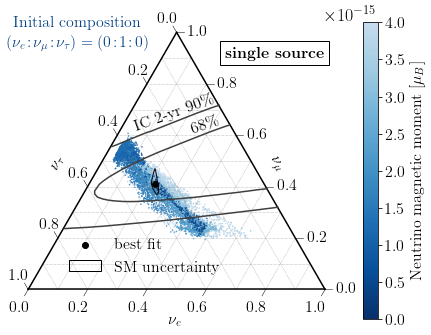

/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


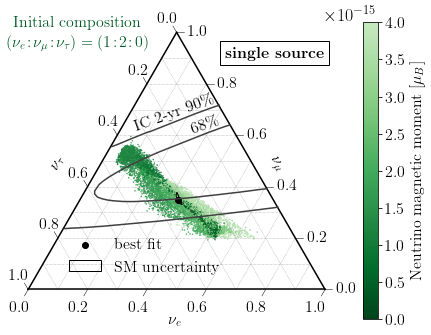

In [73]:
# linear scale - small mu range - Nm=200

/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


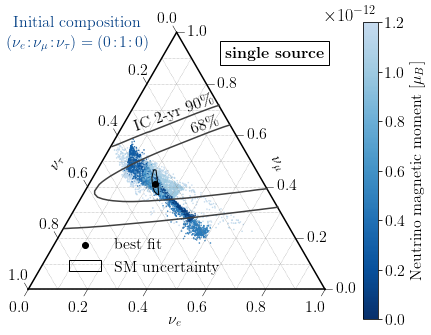

/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


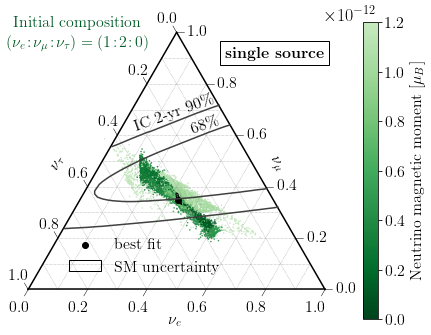

In [19]:
# linear scale - large mu range

/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


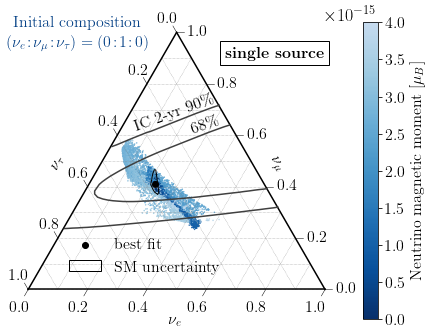

/Users/jkopp/.pyenv/versions/3.8.3/lib/python3.8/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


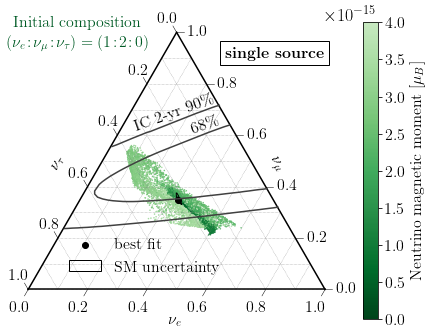

In [220]:
# linear scale - small mu range - Nm=20